In [4]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')

# load visual embeddings
with open('/kaggle/input/v-emb-bal/v_embeds_train.pkl', 'rb') as f:
    v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_val.pkl', 'rb') as f:
    v_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_test.pkl', 'rb') as f:
    v_embeds_test = pickle.load(f) 

In [6]:
print(len(v_embeds_train))
print(v_embeds_train[0].shape)
stacked_tensor = torch.stack(v_embeds_train, dim=0)

print(stacked_tensor.shape)

1602
torch.Size([100, 1024])
torch.Size([1602, 100, 1024])


In [7]:
# stack visual features 
X_train = torch.stack(v_embeds_train, dim=0).cpu().numpy()
X_val = torch.stack(v_embeds_val, dim=0).cpu().numpy()
X_test = torch.stack(v_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1602, 100, 1024) (89, 100, 1024) (89, 100, 1024)


In [8]:
# convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['AUTHOR'])
y_val = label_encoder.transform(df_val['AUTHOR'])
y_test = label_encoder.transform(df_test['AUTHOR'])

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [15]:
# define model using a simple MLP architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(100, 1024)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optim,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

results = [] # store results obtained by training model with 10 different random seeds

for seed in range(10):
    
    np.random.seed(seed) # set random seed
    tf.random.set_seed(seed)

    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # perform early stopping
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
    # evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    # evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

    # get validation and test accuracy for every random seed
    results.append({'seed': seed, 'val_accuracy': val_accuracy, 'test_accuracy': test_accuracy})


results_df = pd.DataFrame(results) # save results 
results_df.to_csv('model_results.csv', index=False)

Epoch 1/20
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1102 - loss: 5.0682

W0000 00:00:1716816401.136217     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1339 - loss: 4.4041

W0000 00:00:1716816402.395624     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1357 - loss: 4.3663 - val_accuracy: 0.2697 - val_loss: 2.1849
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4780 - loss: 1.5467 - val_accuracy: 0.2921 - val_loss: 2.0862
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7038 - loss: 0.9586 - val_accuracy: 0.3483 - val_loss: 2.1405
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8235 - loss: 0.6718 - val_accuracy: 0.3483 - val_loss: 2.3570
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8347 - loss: 0.5715 - val_accuracy: 0.2360 - val_loss: 2.6975
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2945 - loss: 2.1267  
Validation Loss: 2.0862276554107666, Validation Accuracy: 0.2921348214149475
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3741 - loss: 1.8827 
Test Loss: 1.8273131847381592, Test Accuracy: 0.40449437499046326
Epoch 1/20
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0955 - loss: 4.3748

W0000 00:00:1716816408.241557     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1353 - loss: 3.7626

W0000 00:00:1716816409.430873     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1372 - loss: 3.7357 - val_accuracy: 0.2921 - val_loss: 2.1162
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4925 - loss: 1.4469 - val_accuracy: 0.2809 - val_loss: 1.9673
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7086 - loss: 0.9587 - val_accuracy: 0.2921 - val_loss: 2.5080
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7075 - loss: 0.8491 - val_accuracy: 0.4045 - val_loss: 2.0170
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9108 - loss: 0.3829 - val_accuracy: 0.3933 - val_loss: 1.8780
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9605 - loss: 0.2543 - val_accuracy: 0.3483 - val_loss: 2.1541
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9528 - loss: 0.2713 - val_accuracy: 0.3933 - val_loss: 1.9822
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9170 - loss: 0.3308 - val_accuracy: 0.1910 - val_loss: 3.

W0000 00:00:1716816416.785750     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1196 - loss: 3.4433

W0000 00:00:1716816418.052297     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1210 - loss: 3.4213 - val_accuracy: 0.2247 - val_loss: 2.2174
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3954 - loss: 1.7499 - val_accuracy: 0.2697 - val_loss: 2.0788
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6199 - loss: 1.2064 - val_accuracy: 0.2921 - val_loss: 1.9142
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8195 - loss: 0.8205 - val_accuracy: 0.3483 - val_loss: 2.0270
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9003 - loss: 0.5884 - val_accuracy: 0.3034 - val_loss: 2.2707
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8912 - loss: 0.5127 - val_accuracy: 0.3258 - val_loss: 2.2683
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3140 - loss: 1.9056  
Validation Loss: 1.9142365455627441, Validation Accuracy: 0.2921348214149475
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4239 - loss: 1.6489 
Test Loss: 1.61228072643280

W0000 00:00:1716816424.407508     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1240 - loss: 4.2831

W0000 00:00:1716816425.720789     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1257 - loss: 4.2534 - val_accuracy: 0.3034 - val_loss: 2.2289
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4396 - loss: 1.6073 - val_accuracy: 0.3034 - val_loss: 1.9985
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6896 - loss: 1.0512 - val_accuracy: 0.3708 - val_loss: 1.8031
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8384 - loss: 0.7320 - val_accuracy: 0.3371 - val_loss: 1.9797
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8773 - loss: 0.6012 - val_accuracy: 0.4494 - val_loss: 1.8073
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9419 - loss: 0.4088 - val_accuracy: 0.3371 - val_loss: 2.0529
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3885 - loss: 1.7854  
Validation Loss: 1.8030529022216797, Validation Accuracy: 0.37078651785850525
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3893 - loss: 1.6221 
Test Loss: 1.5875083208084

W0000 00:00:1716816432.198500     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1399 - loss: 4.8056

W0000 00:00:1716816433.473611     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1410 - loss: 4.7618 - val_accuracy: 0.2022 - val_loss: 2.3848
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3661 - loss: 1.8720 - val_accuracy: 0.2809 - val_loss: 2.0156
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5925 - loss: 1.2124 - val_accuracy: 0.2584 - val_loss: 2.0648
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7763 - loss: 0.8350 - val_accuracy: 0.2809 - val_loss: 2.0958
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8919 - loss: 0.5578 - val_accuracy: 0.3034 - val_loss: 2.2033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2889 - loss: 1.9747  
Validation Loss: 2.015551805496216, Validation Accuracy: 0.2808988690376282
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3573 - loss: 1.7537 
Test Loss: 1.7023600339889526, Test Accuracy: 0.37078651785850525
Epoch 1/20
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1160 - loss: 3.8795

W0000 00:00:1716816439.754771     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1339 - loss: 3.5330

W0000 00:00:1716816441.022110     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1353 - loss: 3.5139 - val_accuracy: 0.2697 - val_loss: 2.4854
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4320 - loss: 1.6729 - val_accuracy: 0.3258 - val_loss: 2.1068
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6114 - loss: 1.1240 - val_accuracy: 0.3258 - val_loss: 2.3349
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8144 - loss: 0.6365 - val_accuracy: 0.2809 - val_loss: 2.7066
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8090 - loss: 0.6252 - val_accuracy: 0.3596 - val_loss: 2.6168
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3270 - loss: 2.0848  
Validation Loss: 2.106814384460449, Validation Accuracy: 0.3258427083492279
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3309 - loss: 1.8951 
Test Loss: 1.9182958602905273, Test Accuracy: 0.3258427083492279
Epoch 1/20
 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1259 - loss: 3.9339

W0000 00:00:1716816446.710061     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1699 - loss: 3.3763

W0000 00:00:1716816447.960485     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1717 - loss: 3.3550 - val_accuracy: 0.1798 - val_loss: 2.7892
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4124 - loss: 1.8159 - val_accuracy: 0.3146 - val_loss: 2.1617
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7263 - loss: 0.9573 - val_accuracy: 0.3258 - val_loss: 2.1867
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8182 - loss: 0.6711 - val_accuracy: 0.2697 - val_loss: 2.3682
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8066 - loss: 0.5960 - val_accuracy: 0.3146 - val_loss: 2.3924
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3018 - loss: 2.1047  
Validation Loss: 2.1616714000701904, Validation Accuracy: 0.31460675597190857
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3040 - loss: 1.9799 
Test Loss: 1.9072781801223755, Test Accuracy: 0.30337077379226685
Epoch 1/20
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0869 - loss: 4.4494

W0000 00:00:1716816453.868180     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1131 - loss: 3.8255

W0000 00:00:1716816455.133570     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1149 - loss: 3.7971 - val_accuracy: 0.1461 - val_loss: 2.6067
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3663 - loss: 1.8515 - val_accuracy: 0.3258 - val_loss: 2.1543
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5630 - loss: 1.3271 - val_accuracy: 0.3596 - val_loss: 1.7529
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8084 - loss: 0.7674 - val_accuracy: 0.3483 - val_loss: 1.8697
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9095 - loss: 0.4991 - val_accuracy: 0.3034 - val_loss: 2.4175
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8806 - loss: 0.4663 - val_accuracy: 0.3596 - val_loss: 1.8627
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3673 - loss: 1.7361  
Validation Loss: 1.7528648376464844, Validation Accuracy: 0.3595505654811859
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4117 - loss: 1.7145 
Test Loss: 1.60109603404998

W0000 00:00:1716816461.749041     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1371 - loss: 3.8715

W0000 00:00:1716816462.963655     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1383 - loss: 3.8403 - val_accuracy: 0.2584 - val_loss: 2.2798
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4125 - loss: 1.6881 - val_accuracy: 0.2472 - val_loss: 2.0298
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6300 - loss: 1.1626 - val_accuracy: 0.3933 - val_loss: 1.9675
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7882 - loss: 0.7726 - val_accuracy: 0.3483 - val_loss: 1.9797
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8390 - loss: 0.6080 - val_accuracy: 0.3371 - val_loss: 1.7746
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9333 - loss: 0.4174 - val_accuracy: 0.3146 - val_loss: 1.9910
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9470 - loss: 0.3284 - val_accuracy: 0.3820 - val_loss: 2.0809
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9723 - loss: 0.2450 - val_accuracy: 0.3483 - val_loss: 1.

W0000 00:00:1716816470.122121     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1202 - loss: 4.0646

W0000 00:00:1716816471.366995     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1212 - loss: 4.0381 - val_accuracy: 0.2247 - val_loss: 2.4403
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4158 - loss: 1.7157 - val_accuracy: 0.2472 - val_loss: 2.0837
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6744 - loss: 1.0594 - val_accuracy: 0.2584 - val_loss: 1.9414
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8778 - loss: 0.6247 - val_accuracy: 0.2697 - val_loss: 2.1404
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9303 - loss: 0.4286 - val_accuracy: 0.3034 - val_loss: 2.0128
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9647 - loss: 0.3342 - val_accuracy: 0.2697 - val_loss: 2.3069
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2620 - loss: 1.9700  
Validation Loss: 1.9413503408432007, Validation Accuracy: 0.2584269642829895
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3612 - loss: 1.6816 
Test Loss: 1.63176620006561

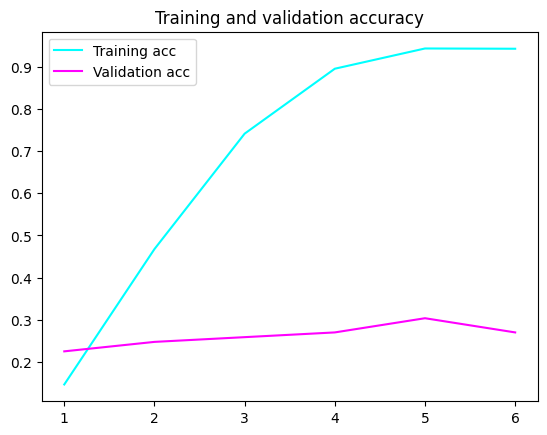

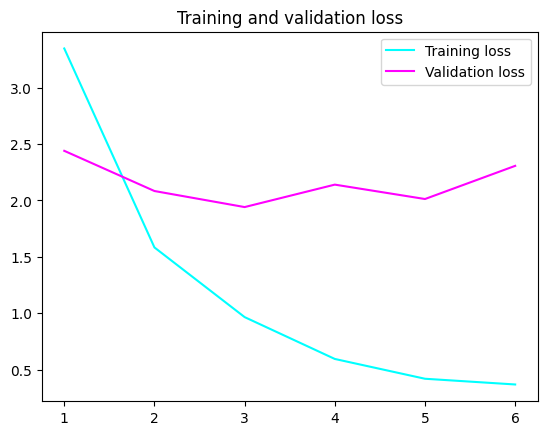

In [16]:
# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model is clearly overfitting (plateau in validation accuracy and loss while the training loss decreases to 0 and the training accuracy reaches 1.0). The data size is relatively small and model might be too complex for this amount of data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


W0000 00:00:1716816516.705856     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


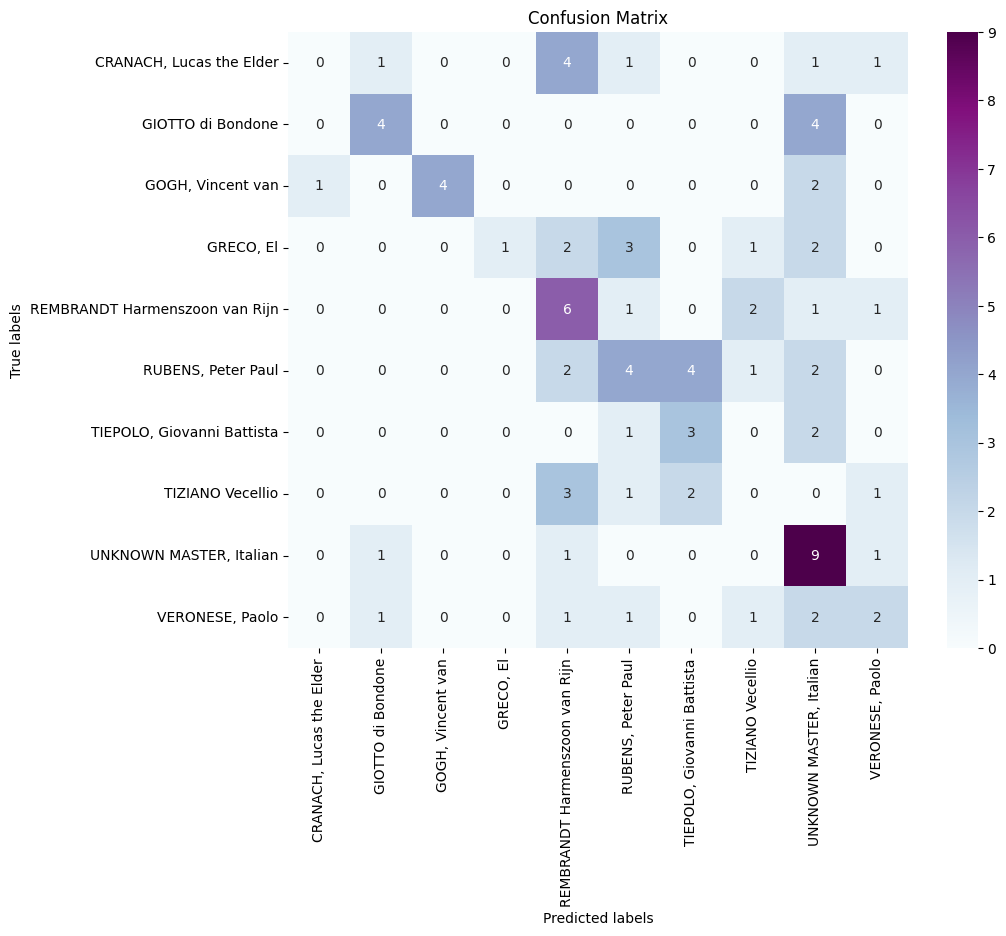

In [17]:
# predictions on test set (Test Accuracy: 0.37078651785850525, random seed = 9)
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Experiment 0: decrease number of Neurons to see whether accuracy increases

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4) # decreased learning rate from 1e-5 to 1e-4
#loss_func = tf.keras.losses.CategoricalCrossentropy() # Note: BERT classifier uses CategoricalCrossentropy() because there, one hot encoding of labels was conducted

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.1299 - loss: 20.3272 - val_accuracy: 0.2247 - val_loss: 8.3257
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3424 - loss: 5.2599 - val_accuracy: 0.2022 - val_loss: 9.3471
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3498 - loss: 4.1362 - val_accuracy: 0.2022 - val_loss: 4.8418
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5520 - loss: 1.5306 - val_accuracy: 0.3371 - val_loss: 3.7205
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7888 - loss: 0.5449 - val_accuracy: 0.2247 - val_loss: 4.1917
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8877 - loss: 0.3274 - val_accuracy: 0.2584 - val_loss: 3.8532
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9474 - loss: 0.1892 - val_accuracy: 0.2472 - val_loss: 3.7473
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3326 - loss: 3.6019  
Validation Loss: 3.7204558849334717, 

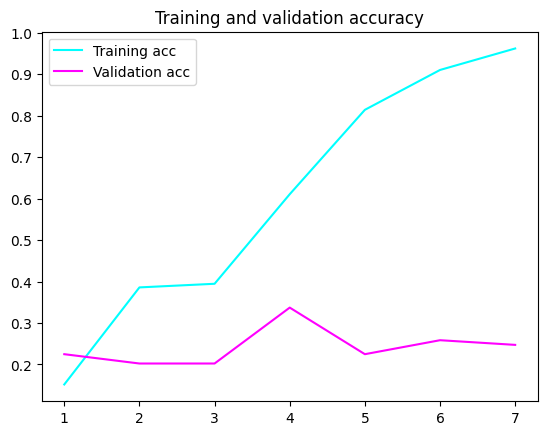

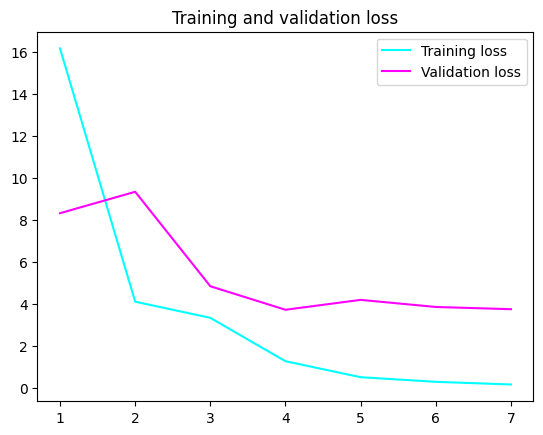

In [13]:
# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Experiment 1
Test to prevent model from overfitting: Add Dropout Layers and BatchNormalization:

Epoch 1/50
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1233 - loss: 3.4542

W0000 00:00:1716397020.874377     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.1407 - loss: 3.3078

W0000 00:00:1716397025.531186     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.1417 - loss: 3.3002 - val_accuracy: 0.0787 - val_loss: 10.6669
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2715 - loss: 2.4051 - val_accuracy: 0.1461 - val_loss: 5.0469
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3120 - loss: 2.1162 - val_accuracy: 0.1685 - val_loss: 3.8385
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3832 - loss: 1.8505 - val_accuracy: 0.3146 - val_loss: 2.1459
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4619 - loss: 1.5436 - val_accuracy: 0.2360 - val_loss: 2.2085
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5265 - loss: 1.3925 - val_accuracy: 0.2584 - val_loss: 2.0916
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5629 - loss: 1.3026 - val_accuracy: 0.3258 - val_loss: 1.9837
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5805 - loss: 1.1828 - val_accuracy: 0.3371 - val_loss:

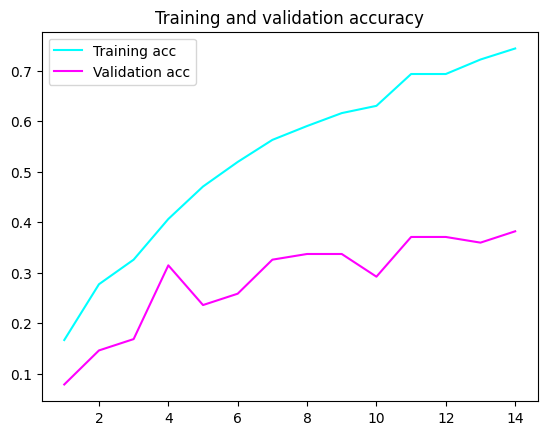

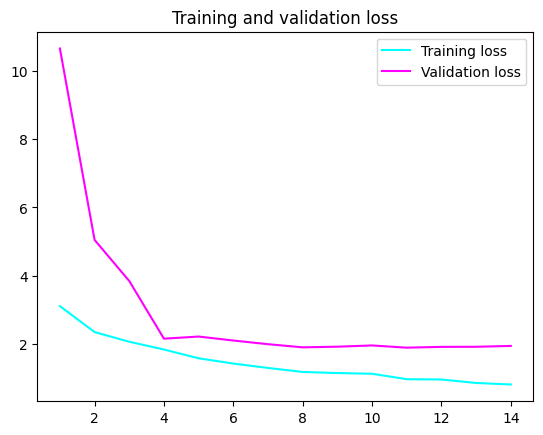

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step

W0000 00:00:1716397098.155780     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


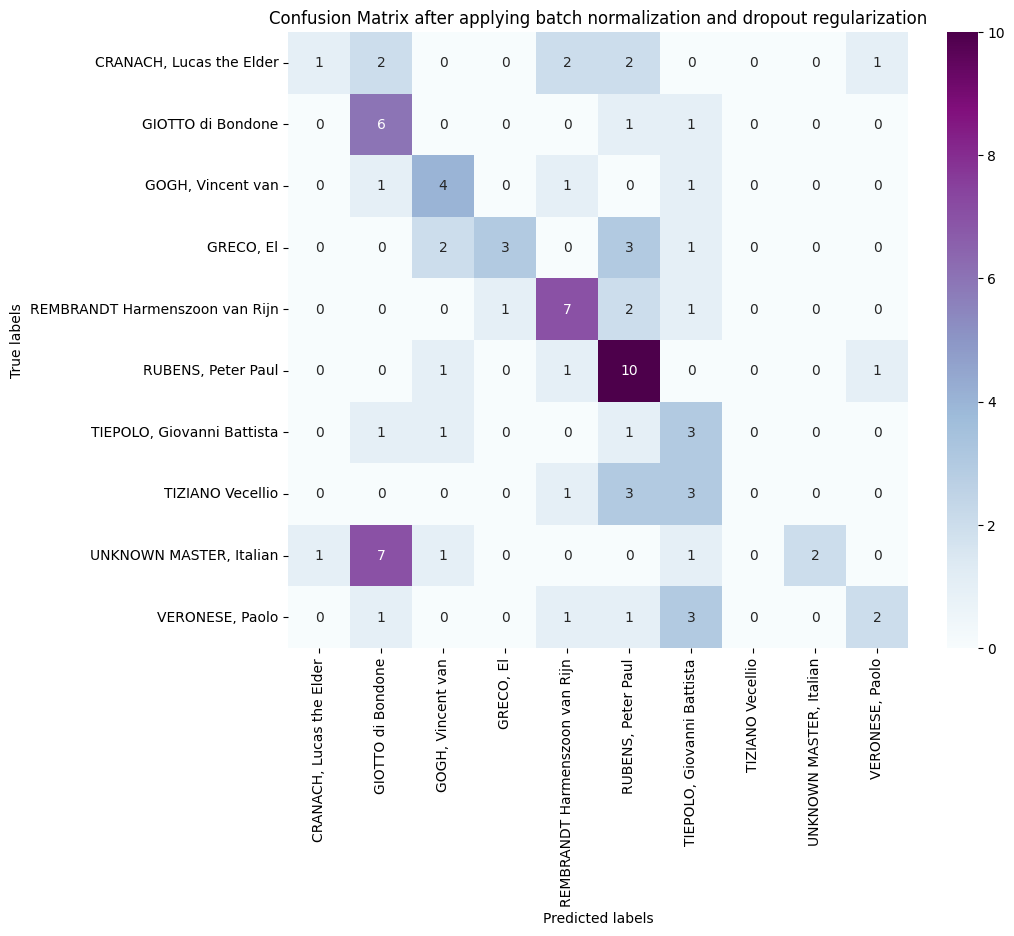

In [15]:
# confusion matrix after applying batch normalization and dropout regularization

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after applying batch normalization and dropout regularization')
plt.show()

## Experiment 2
Use a convolution neural network to enhance model's performance (QUOTE):

Epoch 1/20
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1013 - loss: 2.6460

W0000 00:00:1716397470.934093     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1231 - loss: 2.4812

W0000 00:00:1716397473.318995     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.1243 - loss: 2.4748 - val_accuracy: 0.1573 - val_loss: 2.1054
Epoch 2/20
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2058 - loss: 2.0858

W0000 00:00:1716397473.793331     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2111 - loss: 2.0759 - val_accuracy: 0.2472 - val_loss: 2.0247
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3009 - loss: 1.8972 - val_accuracy: 0.2472 - val_loss: 2.1447
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3443 - loss: 1.7717 - val_accuracy: 0.2584 - val_loss: 1.9676
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3858 - loss: 1.6786 - val_accuracy: 0.3371 - val_loss: 1.8743
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4368 - loss: 1.5630 - val_accuracy: 0.3371 - val_loss: 1.9781
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4170 - loss: 1.5728 - val_accuracy: 0.2921 - val_loss: 1.9268
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4350 - loss: 1.6039 - val_accuracy: 0.3034 - val_loss: 1.8757
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3053 - loss: 1.9248  
Validation Loss: 1.8743046522140503, Validation A

W0000 00:00:1716397478.063128     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 1.6573917865753174, Test Accuracy: 0.4157303273677826


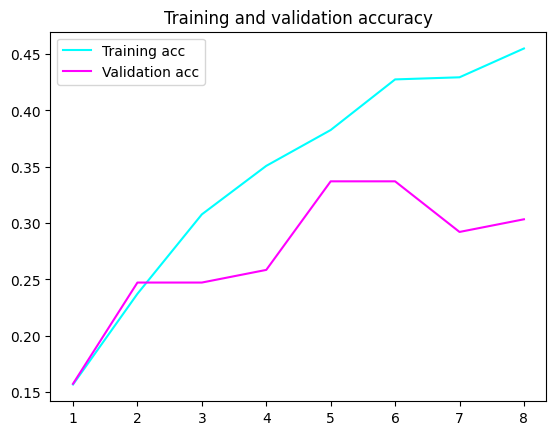

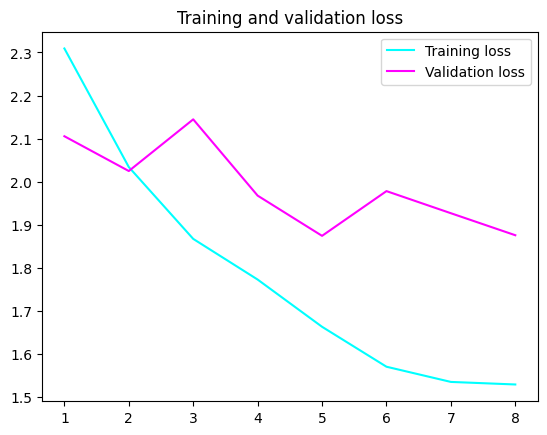

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential

# Define the model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(100, 1024)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step

W0000 00:00:1716397479.424325     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step


W0000 00:00:1716397479.797345     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


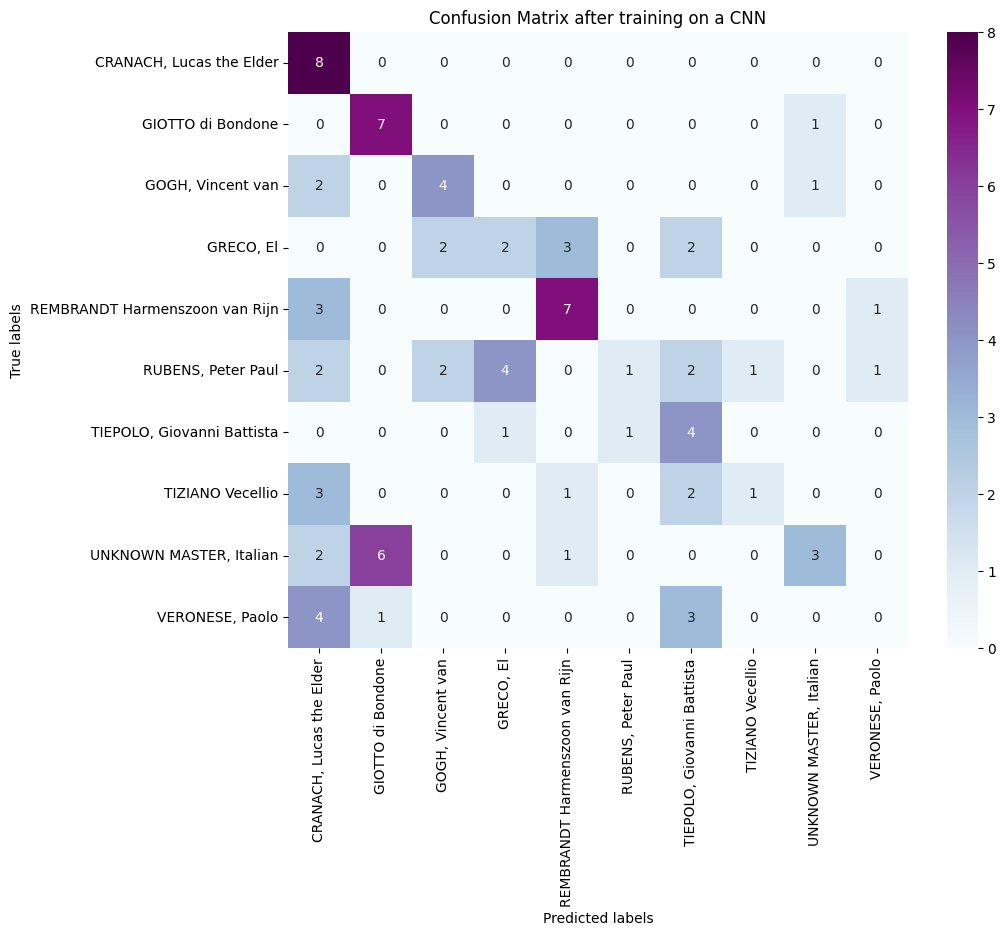

In [18]:
# confusion matrix after applying batch normalization and dropout regularization

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after training on a CNN')
plt.show()